In [242]:
from pandas import read_csv
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import scipy.optimize as opt
import pandas as pd
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [243]:
def clean_data(data):
    # replace NaN with mean/mode for numerical and categoriacal
    for col in data.select_dtypes(include=['number']).columns:
        data[col].fillna(data[col].median(), inplace=True)
    data.drop(['ID'],inplace=True, axis=1)
    return data

def custom_mapping_survey(data):
    # define the mapping for the qualitative categories
    qualitative_mapping = {
        'excellent': 6,
        'good': 5,
        'acceptable': 4,
        'need improvement': 3,
        'poor': 2,
        'extremely poor': 1, 
    }
    seat_mapping = {
        'Green Car': 1,
        'Ordinary': 0,
    }
    # apply qualitative mapping to specified columns
    qualitative_columns = [
        'Seat_comfort', 
        'Arrival_time_convenient', 
        'Catering', 
        'Platform_location', 
        'Onboardwifi_service', 
        'Onboard_entertainment', 
        'Online_support', 
        'Onlinebooking_Ease', 
        'Onboard_service', 
        'Leg_room', 
        'Baggage_handling', 
        'Checkin_service', 
        'Cleanliness', 
        'Online_boarding'
    ]
    for column in qualitative_columns:
        data[column] = data[column].map(qualitative_mapping)
    data['Seat_Class'] = data['Seat_Class'].map(seat_mapping)

    return clean_data(data)

def custom_mapping_travel(data):
    gender_mapping = {
        'Female': 0,
        'Male': 1,
    }
    customer_type_mapping = {
        'Loyal Customer': 1,
        'disloyal Customer': 0,
    }
    travel_type_mapping = {
        'Personal Travel': 0,
        'Business travel': 1,
    }
    travel_class_mapping = {
        'Business': 1,
        'Eco': 0,
    }
    data['Gender'] = data['Gender'].map(gender_mapping)
    data['CustomerType'] = data['CustomerType'].map(customer_type_mapping)
    data['TypeTravel'] = data['TypeTravel'].map(travel_type_mapping)
    data['Travel_Class'] = data['Travel_Class'].map(travel_class_mapping)

    return clean_data(data)
    

def concatenate(df1,df2):
    return pd.concat([df1, df2], axis=1)

def count_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers)

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

def drop_highly_correlated(data, threshold=0.5):
    correlation_matrix = data.corr().abs()
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    highly_correlated_columns = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    data = data.drop(columns=highly_correlated_columns)
    return data

def correlation_matrix_plot(data):
    correlation_matrix = data.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix, 
        mask=mask, 
        annot=True,
        cmap="coolwarm",
        vmax=1, 
        vmin=-1, 
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )
    plt.title("Correlation Matrix (Lower Triangle)")
    plt.show()

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost_function(theta, X, y):
    m = len(y)
    predictions = sigmoid(np.dot(X, theta))
    cost = -1/m * (np.dot(y, np.log(predictions)) + np.dot(1 - y, np.log(1 - predictions)))
    gradient = 1/m * np.dot(X.T, (predictions - y))
    return cost, gradient

def logistic_regression(X_train, y_train, X_test):
    # initialize theta (parameters) to zeros
    initial_beta = np.zeros(X_train.shape[1])
    # perform optimization
    result = opt.minimize(fun=cost_function, x0=initial_beta, args=(X_train, y_train), jac=True, method='TNC')
    # Get beta's
    beta_optimal = result.x
    # predict and convert probabilities
    predictions = sigmoid(np.dot(X_test, beta_optimal))
    binary_predictions = (predictions >= 0.5).astype(int)
    return binary_predictions, result
    

# metric report and plot
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted, digits=3))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, 
                annot=True,  
                fmt='.0f', 
                cmap='Blues', 
                cbar_kws={'label': 'Number of predictions'},
               )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


# Defining a combined boxplot plus histogram function
def hist_box(data, col):
    f, (ax_box, ax_hist) = plt.subplots(2, 
                                        sharex=True, 
                                        gridspec_kw={'height_ratios': (0.15, 0.85)}, 
                                        figsize=(8,5))
    
    sns.boxplot(x = data[col], ax=ax_box, showmeans=True)
    sns.distplot(data[col], ax=ax_hist, bins = 45)
    # adding verticle mean/median lines to distplot to match up with boxplot mean/median
    ax_hist.axvline(data[col].median(), c='k', linestyle = 'dashed', label = 'median')
    ax_hist.axvline(data[col].mean(), c = 'g', linestyle = 'dashed', label = 'mean')
    ax_hist.legend(loc = 0, frameon = False, labelcolor = 'linecolor', fontsize = 15)
    # adjustement of label and label size
    ax_hist.set_xlabel(col, fontsize = 14)
    ax_hist.set_ylabel('Density', fontsize = 14)
    plt.show()
    plt.close()
    print(20*'*'+'End of Box+Hist plot for '+ str(col)+20*'*')

In [244]:
train_travel = pd.read_csv('./shinkansen_travel_data/travel_data_train.csv')
train_survey = pd.read_csv('./shinkansen_travel_data/survey_data_train.csv')

In [245]:
# create the mapping dictionary for 'Platform_location' to math other columns
platform_to_rest_mapping = {
    'very convinient': 'excellent',
    'Convinient': 'good',
    'manageable': 'acceptable',
    'need improvement': 'need improvement',
    'Inconvinient': 'poor',
    'very inconvinient': 'extremely poor',
}
# replace the values in 'Platform_location' using the mapping dictionary
train_survey['Platform_location'] = train_survey['Platform_location'].map(platform_to_rest_mapping)

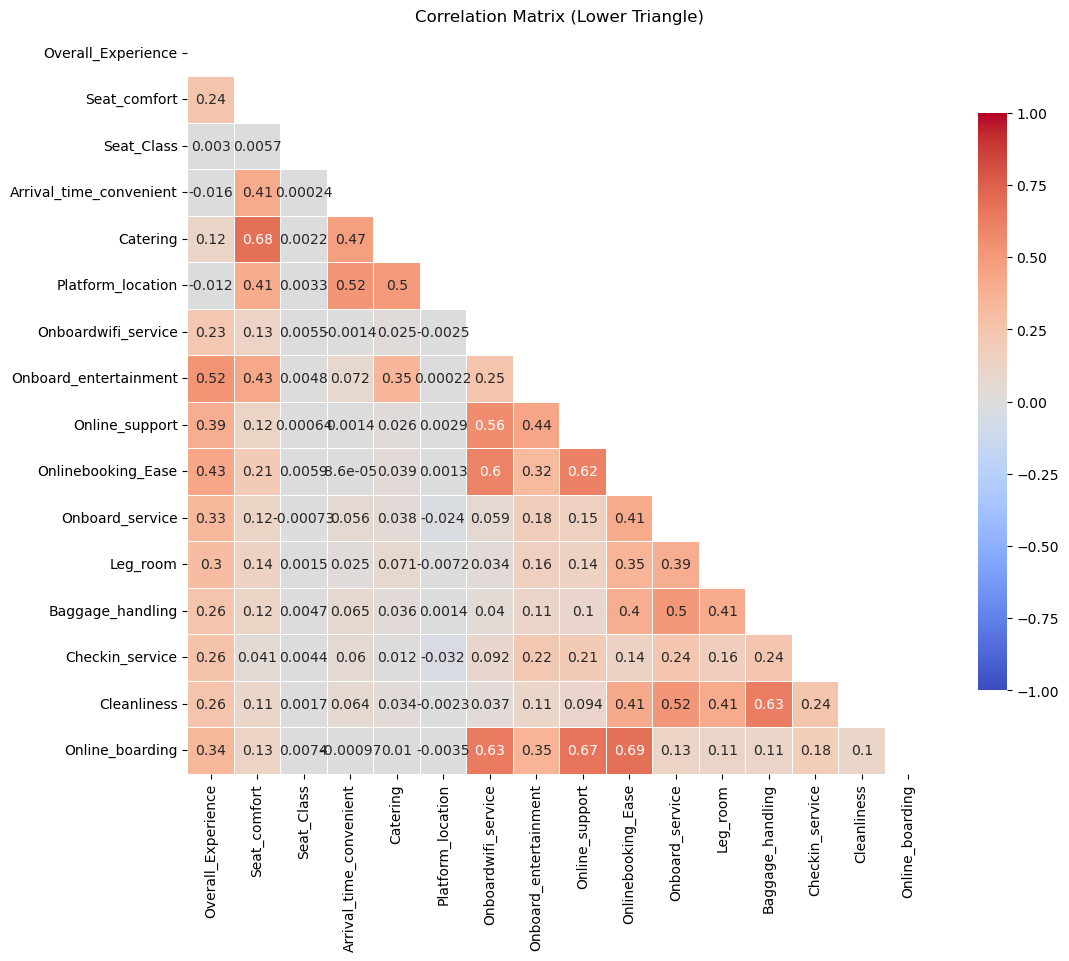

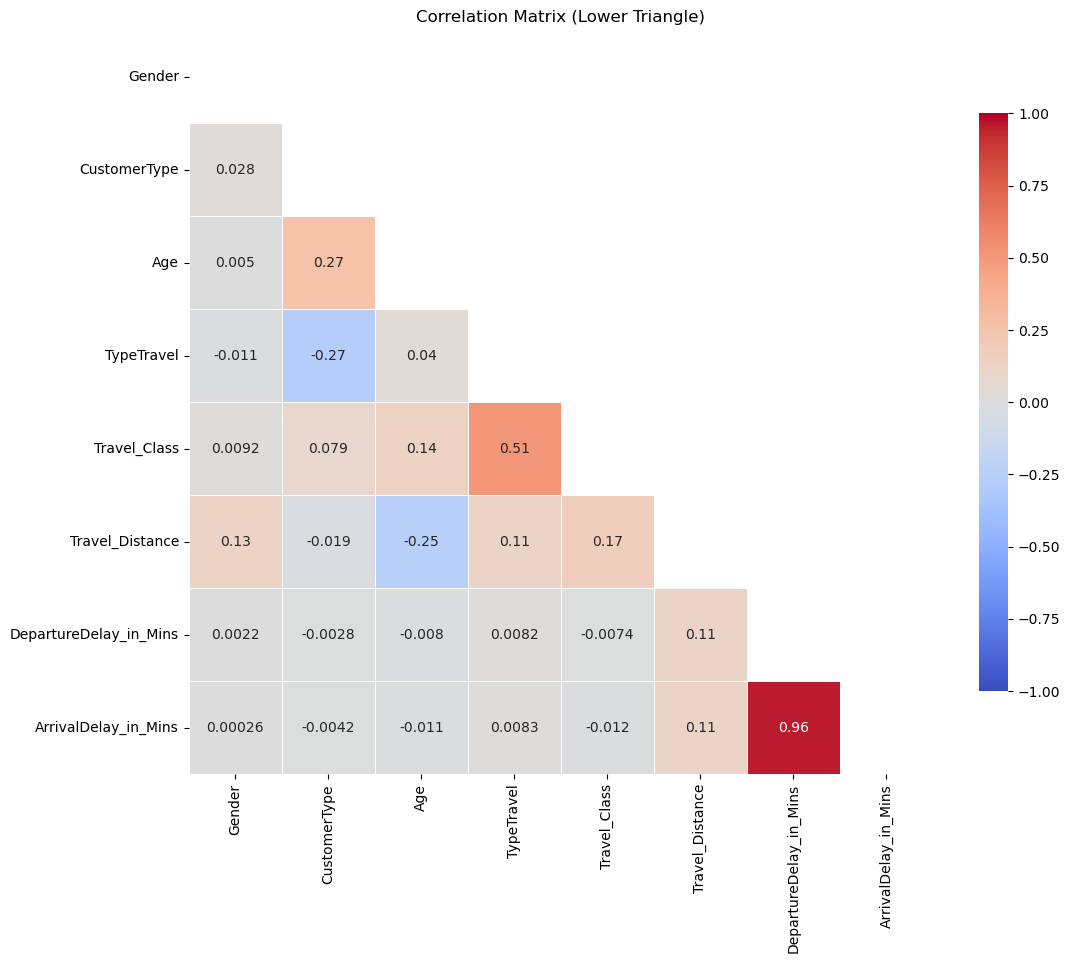

In [246]:
train_travel_clean, train_survey_clean = custom_mapping_travel(train_travel), custom_mapping_survey(train_survey)
# correlations
correlation_matrix_plot(train_survey_clean)
correlation_matrix_plot(train_travel_clean)

In [247]:
train_data = concatenate(train_travel_clean, train_survey_clean)
print("All NaN values handled: ", train_data.isnull().sum().sum() == 0)

All NaN values handled:  True


In [248]:
columns_with_outliers = []
outliers_summary = {}

for column in train_data.columns:
    outlier_count = count_outliers_iqr(train_data, column)
    outliers_summary[column] = outlier_count
    if outlier_count > 10000:  # more than 10% are outliers
        columns_with_outliers.append(column)

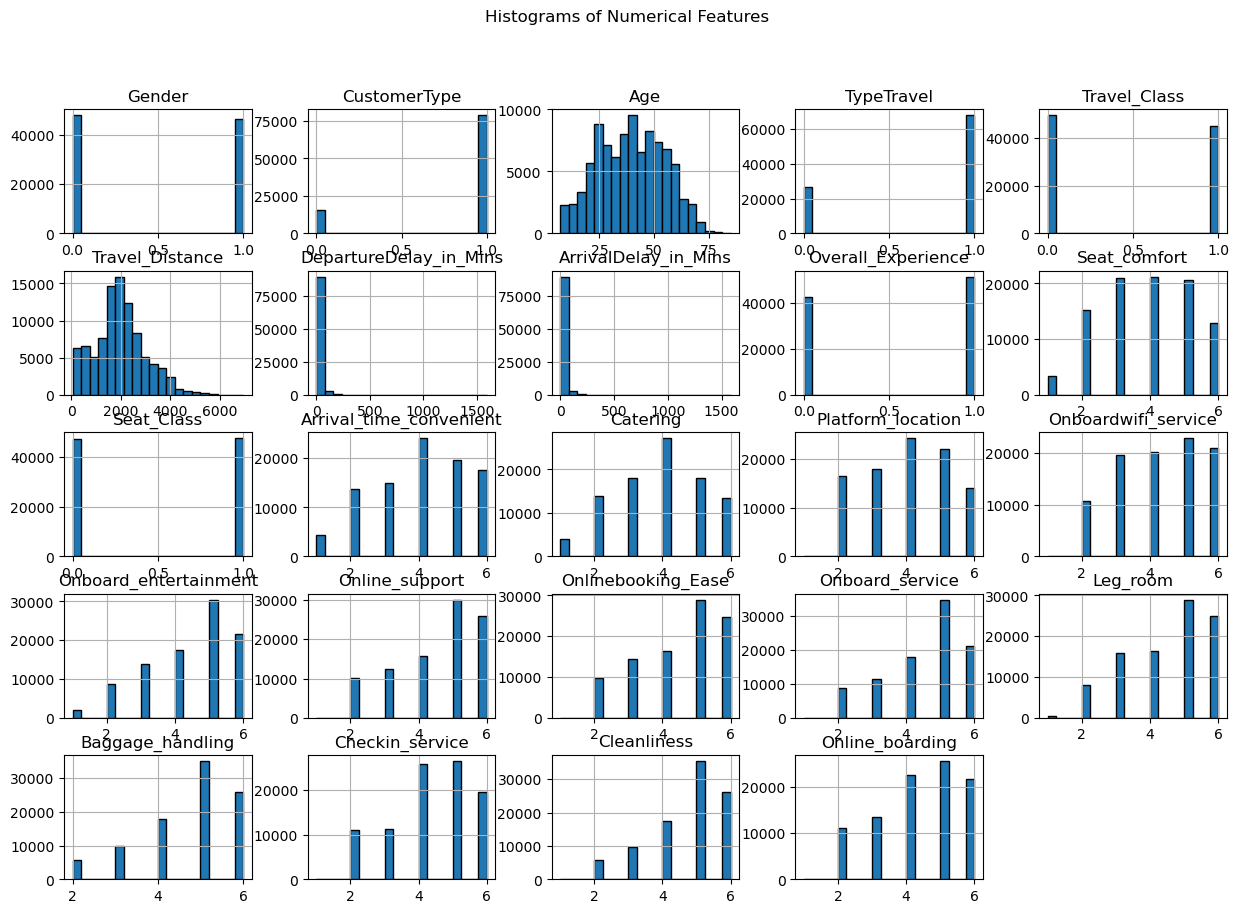

In [249]:
train_data.hist(bins=20, figsize=(15, 10), edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.show()

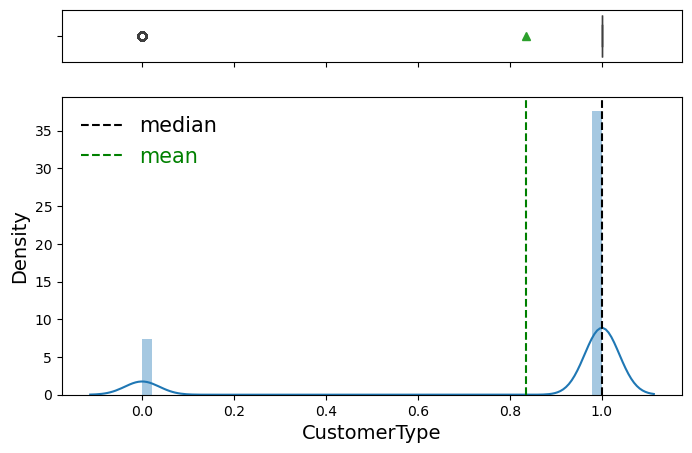

********************End of Box+Hist plot for CustomerType********************


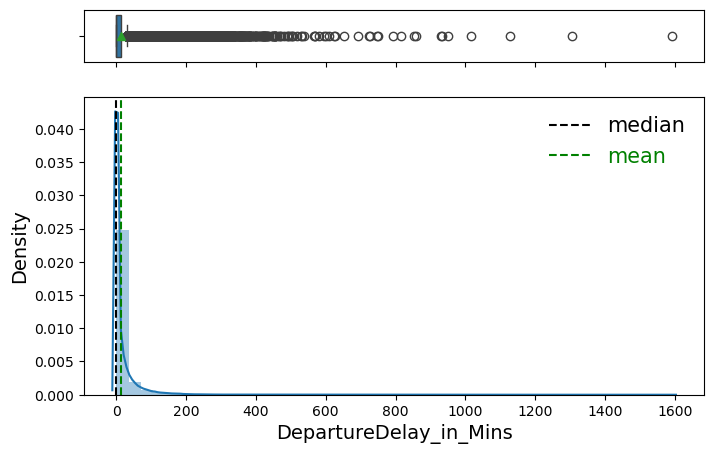

********************End of Box+Hist plot for DepartureDelay_in_Mins********************


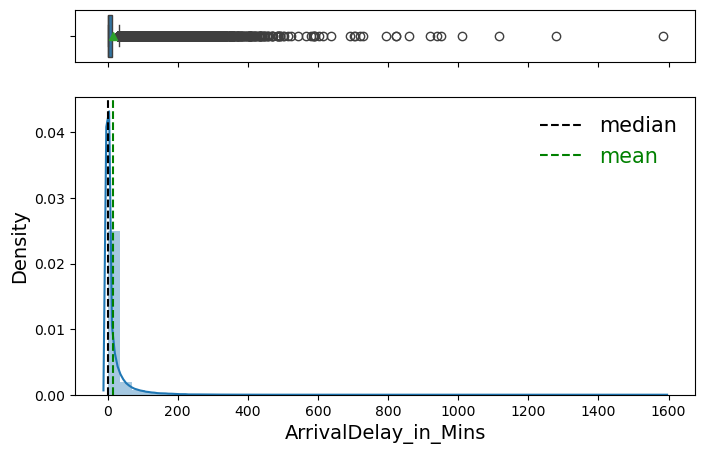

********************End of Box+Hist plot for ArrivalDelay_in_Mins********************


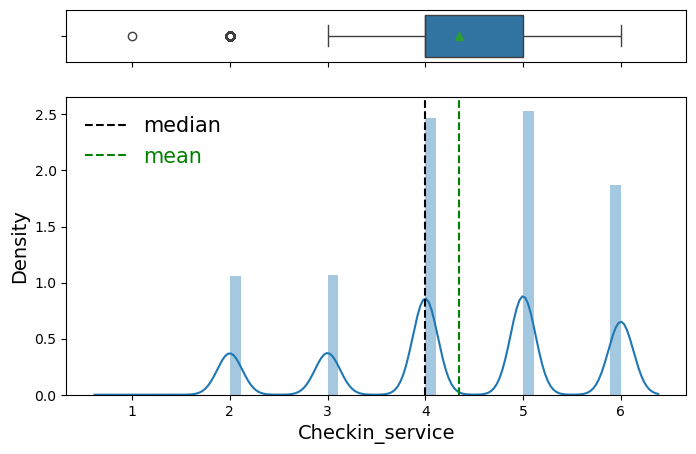

********************End of Box+Hist plot for Checkin_service********************


In [250]:
for col in columns_with_outliers:
    hist_box(train_data, col)

From the distributions and bos plots we notice that the arrival an departure delay columns are hevaily skewed and thus there will be many outliers at the tails of these distributions. This is showing us that on average we do not have much delay in the departure and arrival times, though we see some unique instances of delays ranging from 200 minutes to 1600 minutes. The far end of these tails are highly unlikely cases (potential one-offs) most likely leading to a negative travel expereince and thus we can safetly remove them from our dataset, focusing on the majority of delay times. Also we notice that we have a very unbalanced distribution in loyal to dislaoyal customers. Again disloyal customers are very likely to have left a negative review and thus potentially bias our result oso we may consider remvoing these unique cases as well. Check-in service has a relatively uniform distribution and so we seeme to be suggesting that neutral or need-improvement check-in servic entries are outliers, however, this may not ebe the case and so we will not remove these from our dataset. 

In [251]:
for column in columns_with_outliers:
    train_data = remove_outliers_iqr(train_data, column)

In [252]:
y = train_data['Overall_Experience']
X = train_data.drop(['Overall_Experience'], axis=1)
# drop highly correlated columns to reduce feature space
X = drop_highly_correlated(X, threshold=0.6)
print(X.shape)

(52184, 18)


Training Accuracy: 0.84
Testing Accuracy: 0.83
              precision    recall  f1-score   support

           0      0.774     0.719     0.746      5299
           1      0.861     0.892     0.877     10357

    accuracy                          0.834     15656
   macro avg      0.818     0.806     0.811     15656
weighted avg      0.832     0.834     0.832     15656



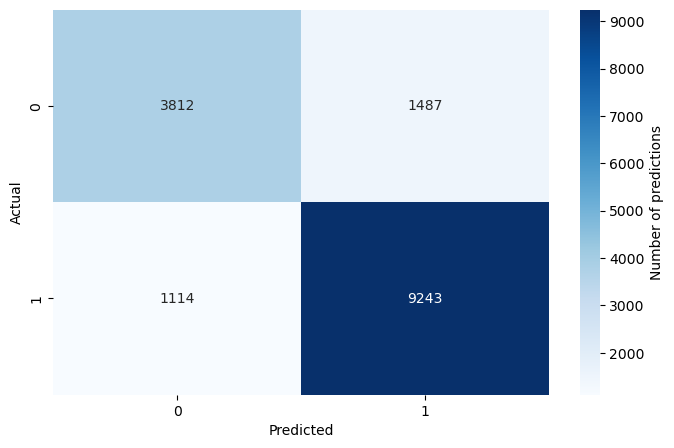

In [253]:
column_names = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
# split data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# apply log reg with cv
log_reg_cv = LogisticRegressionCV(cv=5, penalty='l2')
log_reg_cv.fit(X_train, y_train)
train_accuracy = log_reg_cv.score(X_train, y_train)
test_accuracy = log_reg_cv.score(X_test, y_test)
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Testing Accuracy: {test_accuracy:.2f}')
y_preds_test = log_reg_cv.predict(X_test)
metrics_score(y_test, y_preds_test)

In [254]:
# get the coefficients
coefficients = log_reg_cv.coef_.flatten()
# create a DataFrame for better readability
coef_df = pd.DataFrame({
    'Feature': column_names,
    'Coefficient': coefficients
})
# sort by the absolute value of the coefficients
coef_df['Abs Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False)
print(coef_df_sorted)

                    Feature  Coefficient  Abs Coefficient
11    Onboard_entertainment     0.919601         0.919601
0                    Gender    -0.630350         0.630350
3                TypeTravel     0.527108         0.527108
13       Onlinebooking_Ease     0.525258         0.525258
12           Online_support     0.360256         0.360256
14          Onboard_service     0.351455         0.351455
17          Checkin_service     0.345923         0.345923
15                 Leg_room     0.322455         0.322455
9   Arrival_time_convenient    -0.300891         0.300891
6      ArrivalDelay_in_Mins    -0.173478         0.173478
10      Onboardwifi_service    -0.109340         0.109340
16         Baggage_handling     0.076035         0.076035
7              Seat_comfort     0.072261         0.072261
5    DepartureDelay_in_Mins     0.023280         0.023280
2                       Age    -0.011276         0.011276
8                Seat_Class    -0.008325         0.008325
4           Tr

We see that our model points to the following importaint features:

1. Onboard etertainment: This tells us that for higher values on onborad entertainment( i.e. good and excellent) we are more likely to predict a satisfied customer.
2. Gender: This coefficient tells us that Males (value 1) are more likely to give negative feedback than Females (value 0) i nthis particular dataset.
3. Online Booking Ease: Customers that had a positive experience with online booking tended to be more satisfied customers
4. Travel class: Business class customers tend to leave poisitive feedback over economy customers, likely due to the extra features and advantages of being in business class.

Some other things to point out are that leg room and seat comfort can help predict more satisfied customers but do not have as strong of a relationship as the services provided at checkin, boarding or online by employees for instance. Thus, good employees that are hepful to customers can lead to a positive expereince even if the customer is in economy class with lower levels of comfort.

In [255]:
# fit Bernoulli Naive Bayes model
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
# pred and eval
y_pred_train = bnb.predict(X_train)
y_pred_test = bnb.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Bernoulli Naive Bayes Train Accuracy: {accuracy_train:.2f}')
print(f'Bernoulli Naive Bayes Test Accuracy: {accuracy_test:.2f}')

Bernoulli Naive Bayes Train Accuracy: 0.82
Bernoulli Naive Bayes Test Accuracy: 0.82


              precision    recall  f1-score   support

           0      0.713     0.768     0.739      5299
           1      0.876     0.842     0.859     10357

    accuracy                          0.817     15656
   macro avg      0.795     0.805     0.799     15656
weighted avg      0.821     0.817     0.818     15656



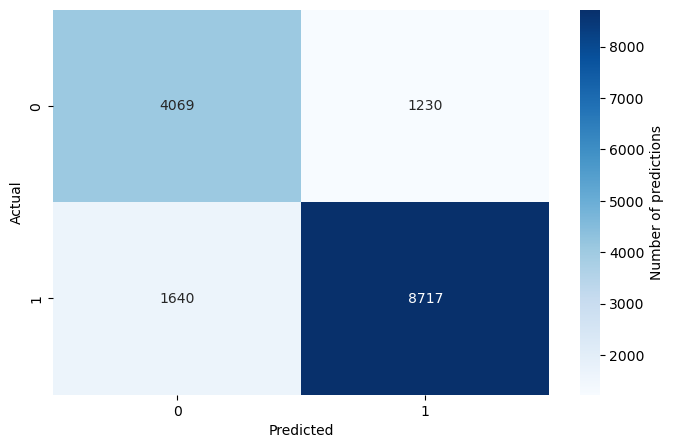

In [256]:
metrics_score(y_test, y_pred_test)